In [1]:
import sys 
sys.path.append("../")

import abc 
import itertools
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass, replace, field
from rl.distribution import Distribution, Constant
from rl.markov_process import MarkovProcess, NonTerminal
from typing import Optional, Mapping, Dict, Tuple, TypeVar, Iterable, Sequence, Callable, Iterator, List

plt.rcParams['figure.figsize'] = (15, 7)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

### I create an abstract class `MarketMakerSimulator`:

In [2]:
@dataclass(frozen=True)
class MarketMakerSimulator(abc.ABC):
    c : float 
    k : float
    S0 : float 
    I0 : float
    T : float 
    dt : float 
    sigma : float 

    @dataclass
    class Market:
        bid : float 
        ask : float 
        time : float 
        midpoint : float
        inventory : int 
        PnL : float 
        num_hits : int 
        num_lifts : int

        def GetSpread(self):
            return self.ask - self.bid
        

    def IsHitOrLifted(self, mid : float, price : float) -> bool:
        delta = mid - price
        prob = self.c * np.exp(-1.0 * self.k * delta) * self.dt

        return np.random.uniform() < prob

    def simulate(self) -> Iterator[Market]:
        pnl = 0.0
        midpoint = self.S0
        inventory = self.I0
        num_hits = num_lifts = 0
        bid, ask = self.CalculatePrices(mid=midpoint, inventory=inventory, time=0.0)

        for t in np.arange(stop=self.T, step=self.dt):
            yield self.Market(bid=round(bid, 2), ask=round(ask, 2), time=round(self.T, 2), 
                     midpoint=round(midpoint, 2), inventory=inventory, 
                     PnL=round(pnl, 2), num_hits=num_hits, num_lifts=num_lifts)

            if self.IsHitOrLifted(midpoint, bid):
                pnl -= bid 
                inventory += 1
                num_hits += 1

            if self.IsHitOrLifted(ask, midpoint):
                pnl += ask
                inventory -= 1
                num_lifts += 1

            midpoint += np.random.choice([-1.0, 1.0]) * self.sigma * np.sqrt(self.dt)
            bid, ask = self.CalculatePrices(mid=midpoint, inventory=inventory, time=t)

        pnl += inventory * midpoint
        yield self.Market(bid=round(bid, 2), ask=round(ask, 2), time=round(self.T, 2), 
                     midpoint=round(midpoint, 2), inventory=inventory, 
                     PnL=round(pnl, 2), num_hits=num_hits, num_lifts=num_lifts)

    @abc.abstractmethod
    def CalculatePrices(self, mid : float, inventory : int, time : float) -> Tuple[float, float]:
        pass

### Then I create `OptimalMarketMaker` by inheriting from `MarketMaker`:

In [3]:
@dataclass(frozen=True)
class OptimalMarketMaker(MarketMakerSimulator):
    gamma : float

    def CalculatePrices(self, mid : float, inventory : int, time : float) -> Tuple[float, float]:
        bid_diff = float(2 * inventory + 1)
        ask_diff = float(1 - 2 * inventory)
        diff = np.array([bid_diff, ask_diff])

        diff *= 0.5 * self.gamma * (self.sigma ** 2) * (self.T - time)
        diff += np.log(1 + self.gamma / self.k) / self.gamma

        return mid - diff[0], mid + diff[1]

### Play with the `OptimalMarketMaker` class:

In [4]:
c = 140.0
k = 1.5
I0 = 0
S0 = 100.0
T = 1.0
dt = 0.005
gamma = 0.1
sigma = 2.0


OMM = OptimalMarketMaker(c=c, k=k, I0=I0, S0=S0, T=T, dt=dt, sigma=sigma, gamma=gamma)
traces = [i for i in OMM.simulate()]

### Plotting the mid, bid and ask prices over time

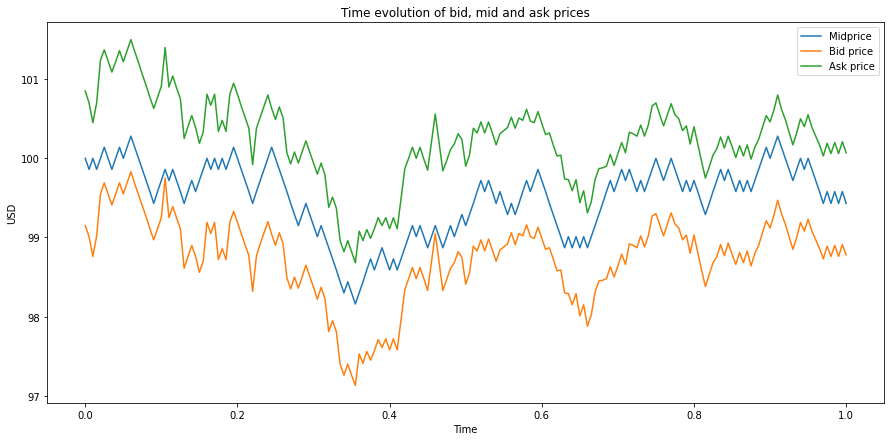

In [5]:
mid = [state.midpoint for state in traces]
bid = [state.bid for state in traces]
ask = [state.ask for state in traces]


plt.plot(np.arange(stop=T + dt, step=dt), mid, label='Midprice')
plt.plot(np.arange(stop=T + dt, step=dt), bid, label='Bid price')
plt.plot(np.arange(stop=T + dt, step=dt), ask, label='Ask price')

plt.xlabel("Time")
plt.ylabel("USD")
plt.title("Time evolution of bid, mid and ask prices")
plt.legend()
plt.show()

### How does the inventory change over time?

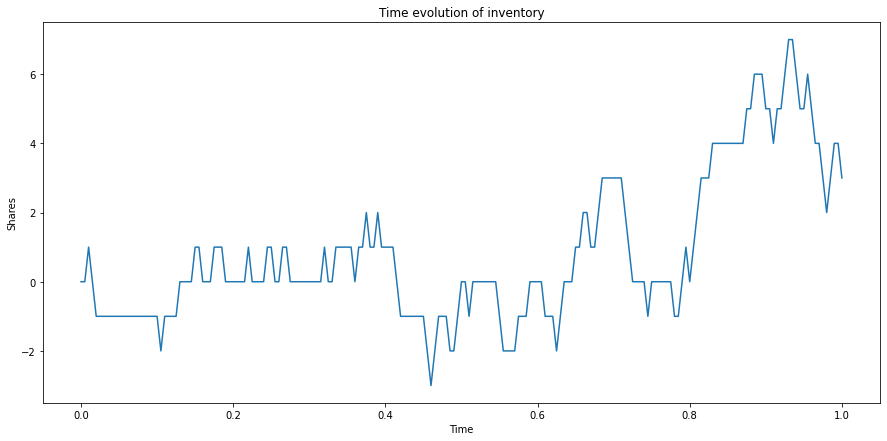

In [6]:
inv = [state.inventory for state in traces]

plt.plot(np.arange(stop=T + dt, step=dt), inv)

plt.xlabel("Time")
plt.ylabel("Shares")
plt.title("Time evolution of inventory")
plt.show()